<a href="https://colab.research.google.com/github/douglasmmachado/MedicineConsumption/blob/causal_model/notebooks/unified_approach/4_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4 - Clustering process and validation



---



---



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import math as m

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

df_url ="https://raw.githubusercontent.com/douglasmmachado/ExploratoryDataAnalysis/causal_model/datasets/unified_approach/df_ma.csv"

numerical_features = ['LIT_HC', 'LIT_HP', 'N_ETB',
'N_UFS', 'PN_MEDICAL', 'POPULATION',
'P_MEDICAL', 'QUANTITY', 'QUANTITY_MA',
'SEJ_HAD', 'SEJ_MCO', 'SEJ_PSY',
'SEJ_SLD', 'SEJ_SSR']

df = pd.read_csv(df_url)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4074 entries, 0 to 4073
Data columns (total 48 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   HOSPI_CODE_UCD     4074 non-null   int64  
 1   LIT_HC             4074 non-null   float64
 2   LIT_HP             4074 non-null   float64
 3   N_ETB              4074 non-null   float64
 4   N_UFS              4074 non-null   float64
 5   PN_MEDICAL         4074 non-null   float64
 6   POPULATION         4074 non-null   float64
 7   P_MEDICAL          4074 non-null   float64
 8   QUANTITY           4074 non-null   float64
 9   QUANTITY_MA        4074 non-null   float64
 10  SEJ_HAD            4074 non-null   float64
 11  SEJ_MCO            4074 non-null   float64
 12  SEJ_PSY            4074 non-null   float64
 13  SEJ_SLD            4074 non-null   float64
 14  SEJ_SSR            4074 non-null   float64
 15  MONTH_1.0          4074 non-null   int64  
 16  MONTH_2.0          4074 

In [ ]:
def plot_df(df, n_cols=3):
    numerical_cols = df.select_dtypes(include=[int, float]).columns
    num_features = len(numerical_cols)
    n_rows = (num_features - 1) // n_cols + 1

    fig, axes = plt.subplots(n_rows, n_cols, sharex=False, figsize=(20, 20))

    for i, column in enumerate(numerical_cols):
        values = df[column].dropna()
        if not values.empty:
            ax = axes[i // n_cols, i % n_cols]
            ax.plot(values)
            ax.set_title('Values of: ' + str(column))
            ax.grid(True)
            plt.grid()

    # Remove empty subplots
    if num_features < n_rows * n_cols:
        for i in range(num_features, n_rows * n_cols):
            fig.delaxes(axes[i // n_cols, i % n_cols])

    plt.tight_layout()
    plt.show()

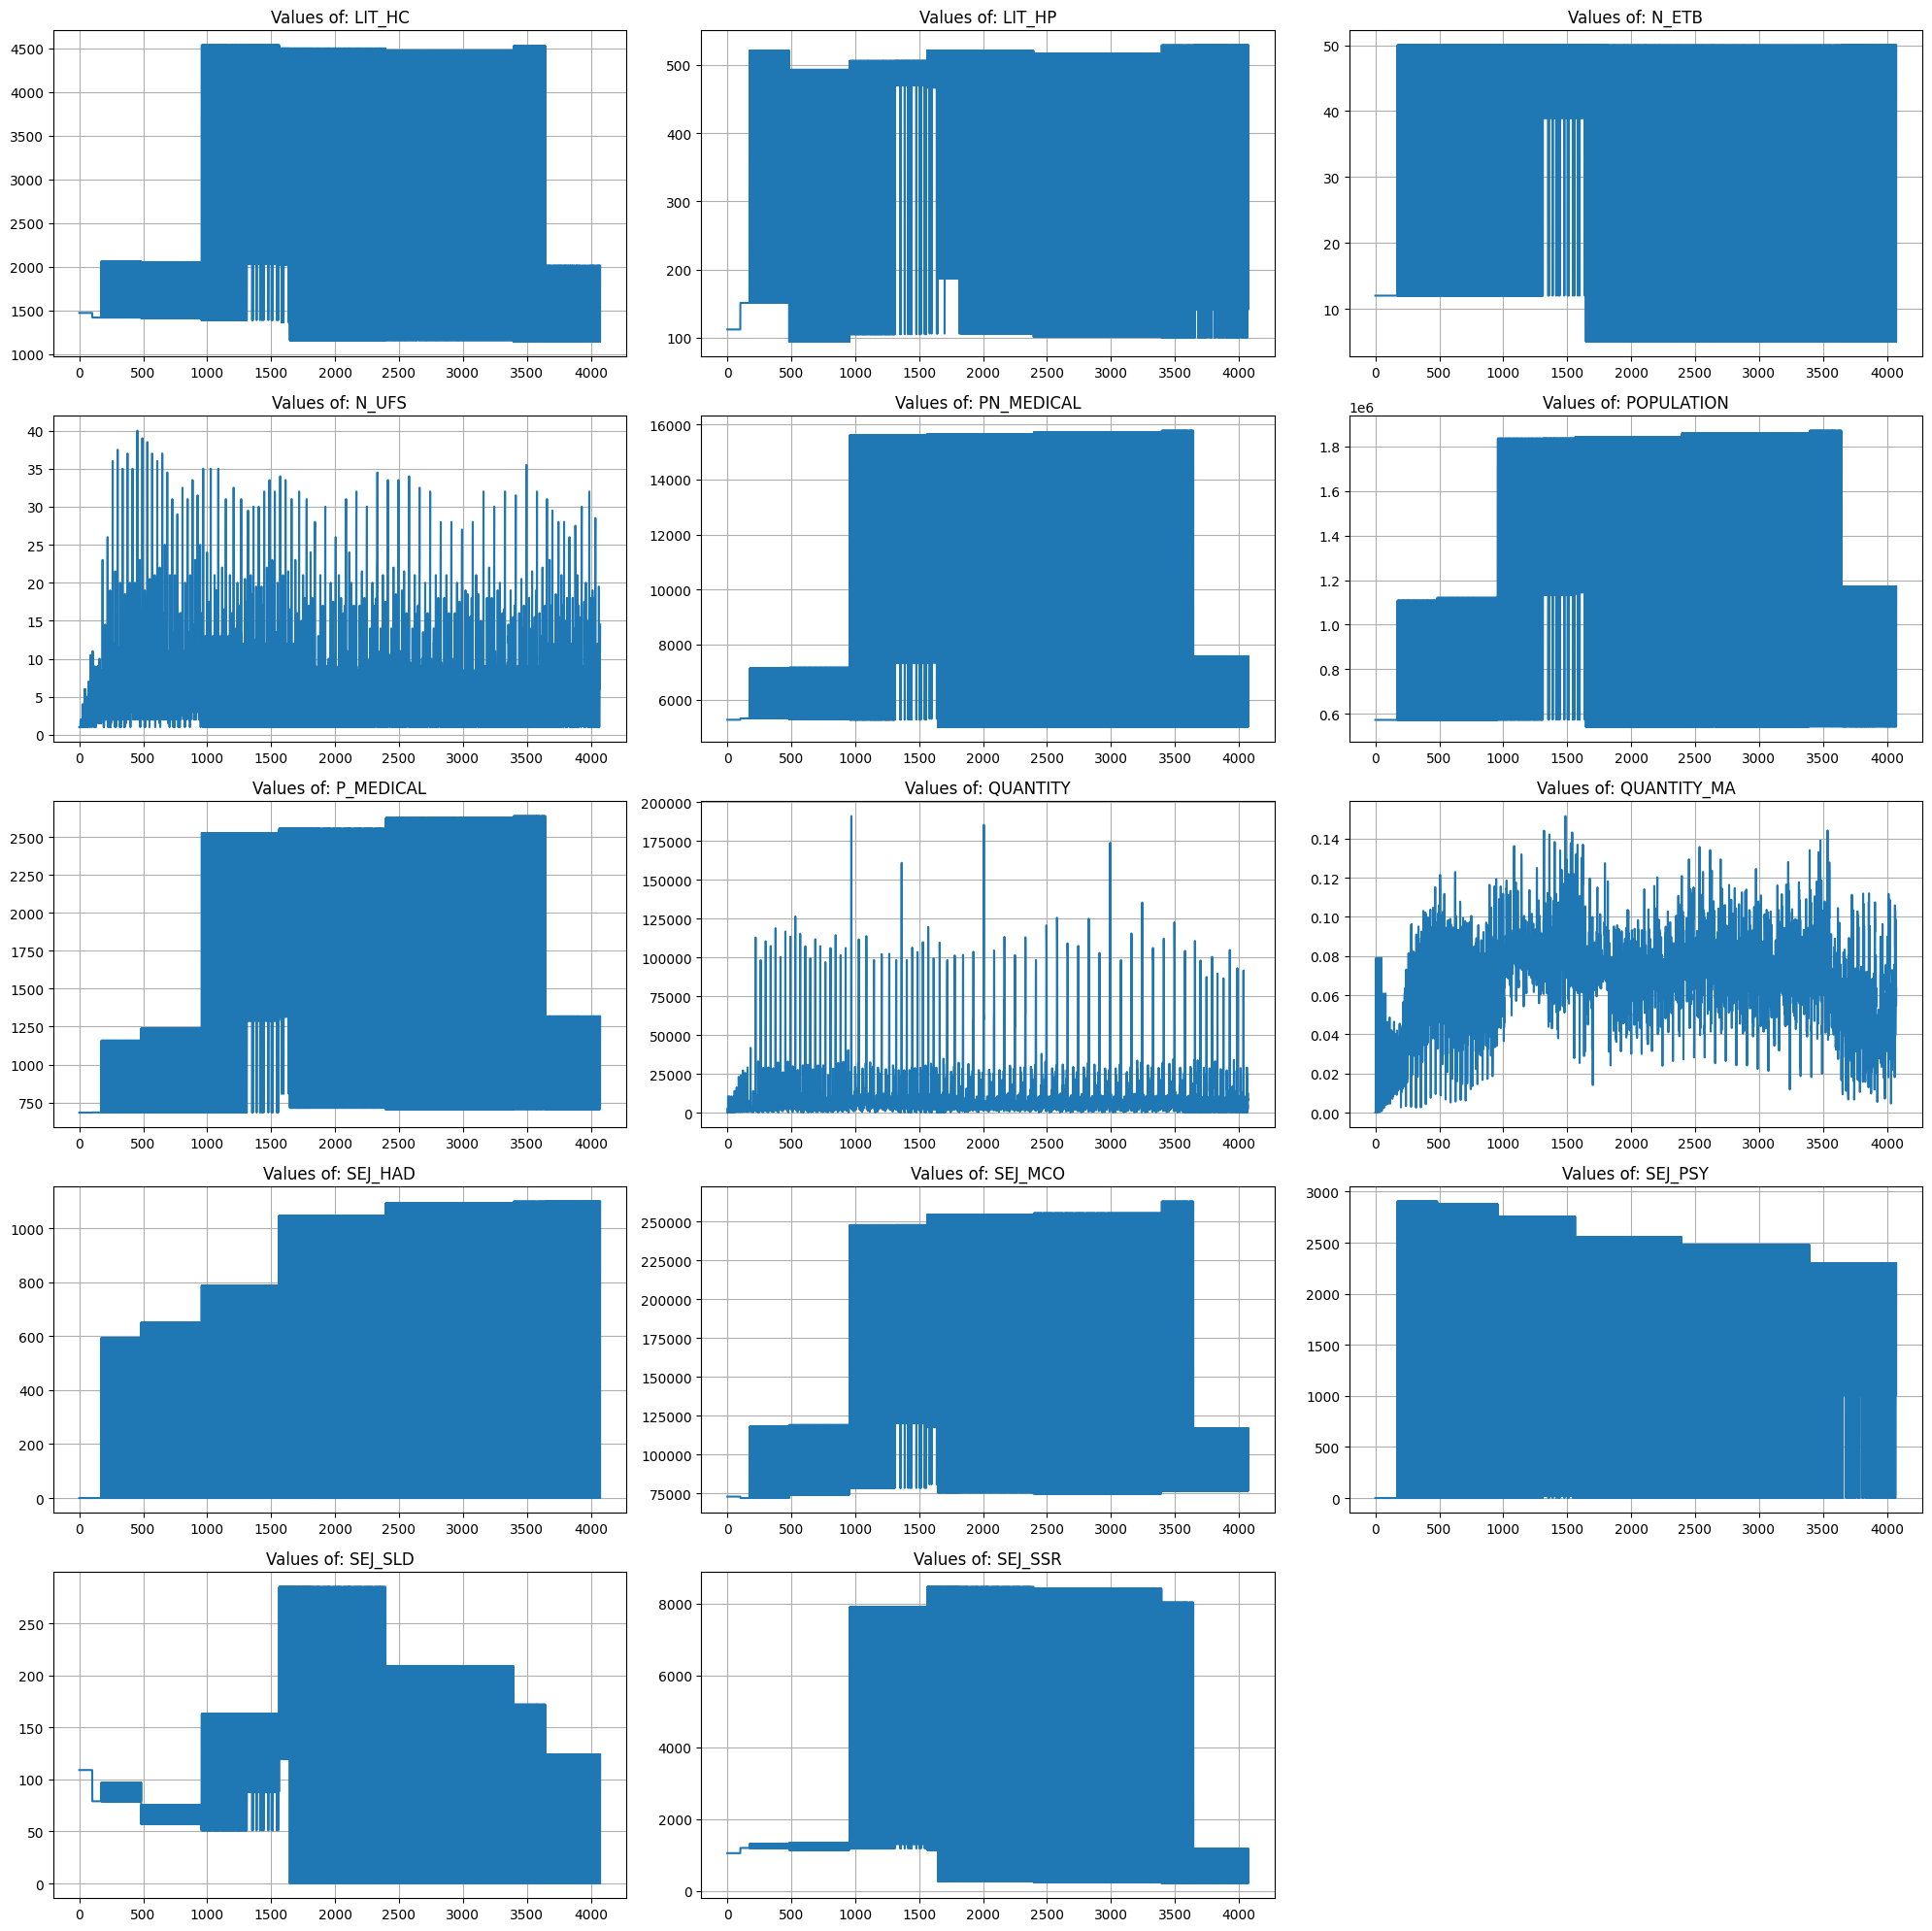

In [ ]:
plot_df(df[numerical_features].copy(), n_cols=3)

In [ ]:
def visualize_distribution(df, data_type='numerical', n_cols=3):
    if data_type == 'numerical':
        columns = df.select_dtypes(include=[int, float]).columns
    elif data_type == 'categorical':
        columns = df.select_dtypes(include=[object, 'string']).columns
    else:
        raise ValueError("Invalid data_type parameter. Supported values: 'numerical', 'categorical'")

    if len(columns) == 0:
        raise ValueError("No columns of the specified data type found in the DataFrame.")

    num_features = len(columns)
    n_rows = m.ceil(num_features / n_cols)

    # Handle the case when n_rows or n_cols is 1
    if n_rows == 1:
        fig, axes = plt.subplots(n_rows, n_cols, sharex=False, figsize=(20, 10))
        axes = [axes]  # Wrap the single axis in a list
    elif n_cols == 1:
        fig, axes = plt.subplots(n_rows, n_cols, sharex=False, figsize=(10, 20))
        axes = [[ax] for ax in axes]  # Convert each axis to a list
    else:
        fig, axes = plt.subplots(n_rows, n_cols, sharex=False, figsize=(20, 20))

    # Set a predefined color palette
    palette = sns.color_palette("Set3", n_colors=num_features)

    for i, column in enumerate(columns):
        ax = axes[i // n_cols][i % n_cols]  # Access the axis correctly
        if data_type == 'numerical':
            sns.histplot(df[column], kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4), ax=ax)
        elif data_type == 'categorical':
            sns.countplot(x=column, data=df, ax=ax, palette=[palette[i]])
            ax.tick_params(axis='x', rotation=45)
        ax.set(title='Distribution of: ' + str(column))

    # Remove empty subplots
    if num_features < n_rows * n_cols:
        for i in range(num_features, n_rows * n_cols):
            fig.delaxes(axes[i // n_cols][i % n_cols])

    plt.tight_layout()
    plt.show()

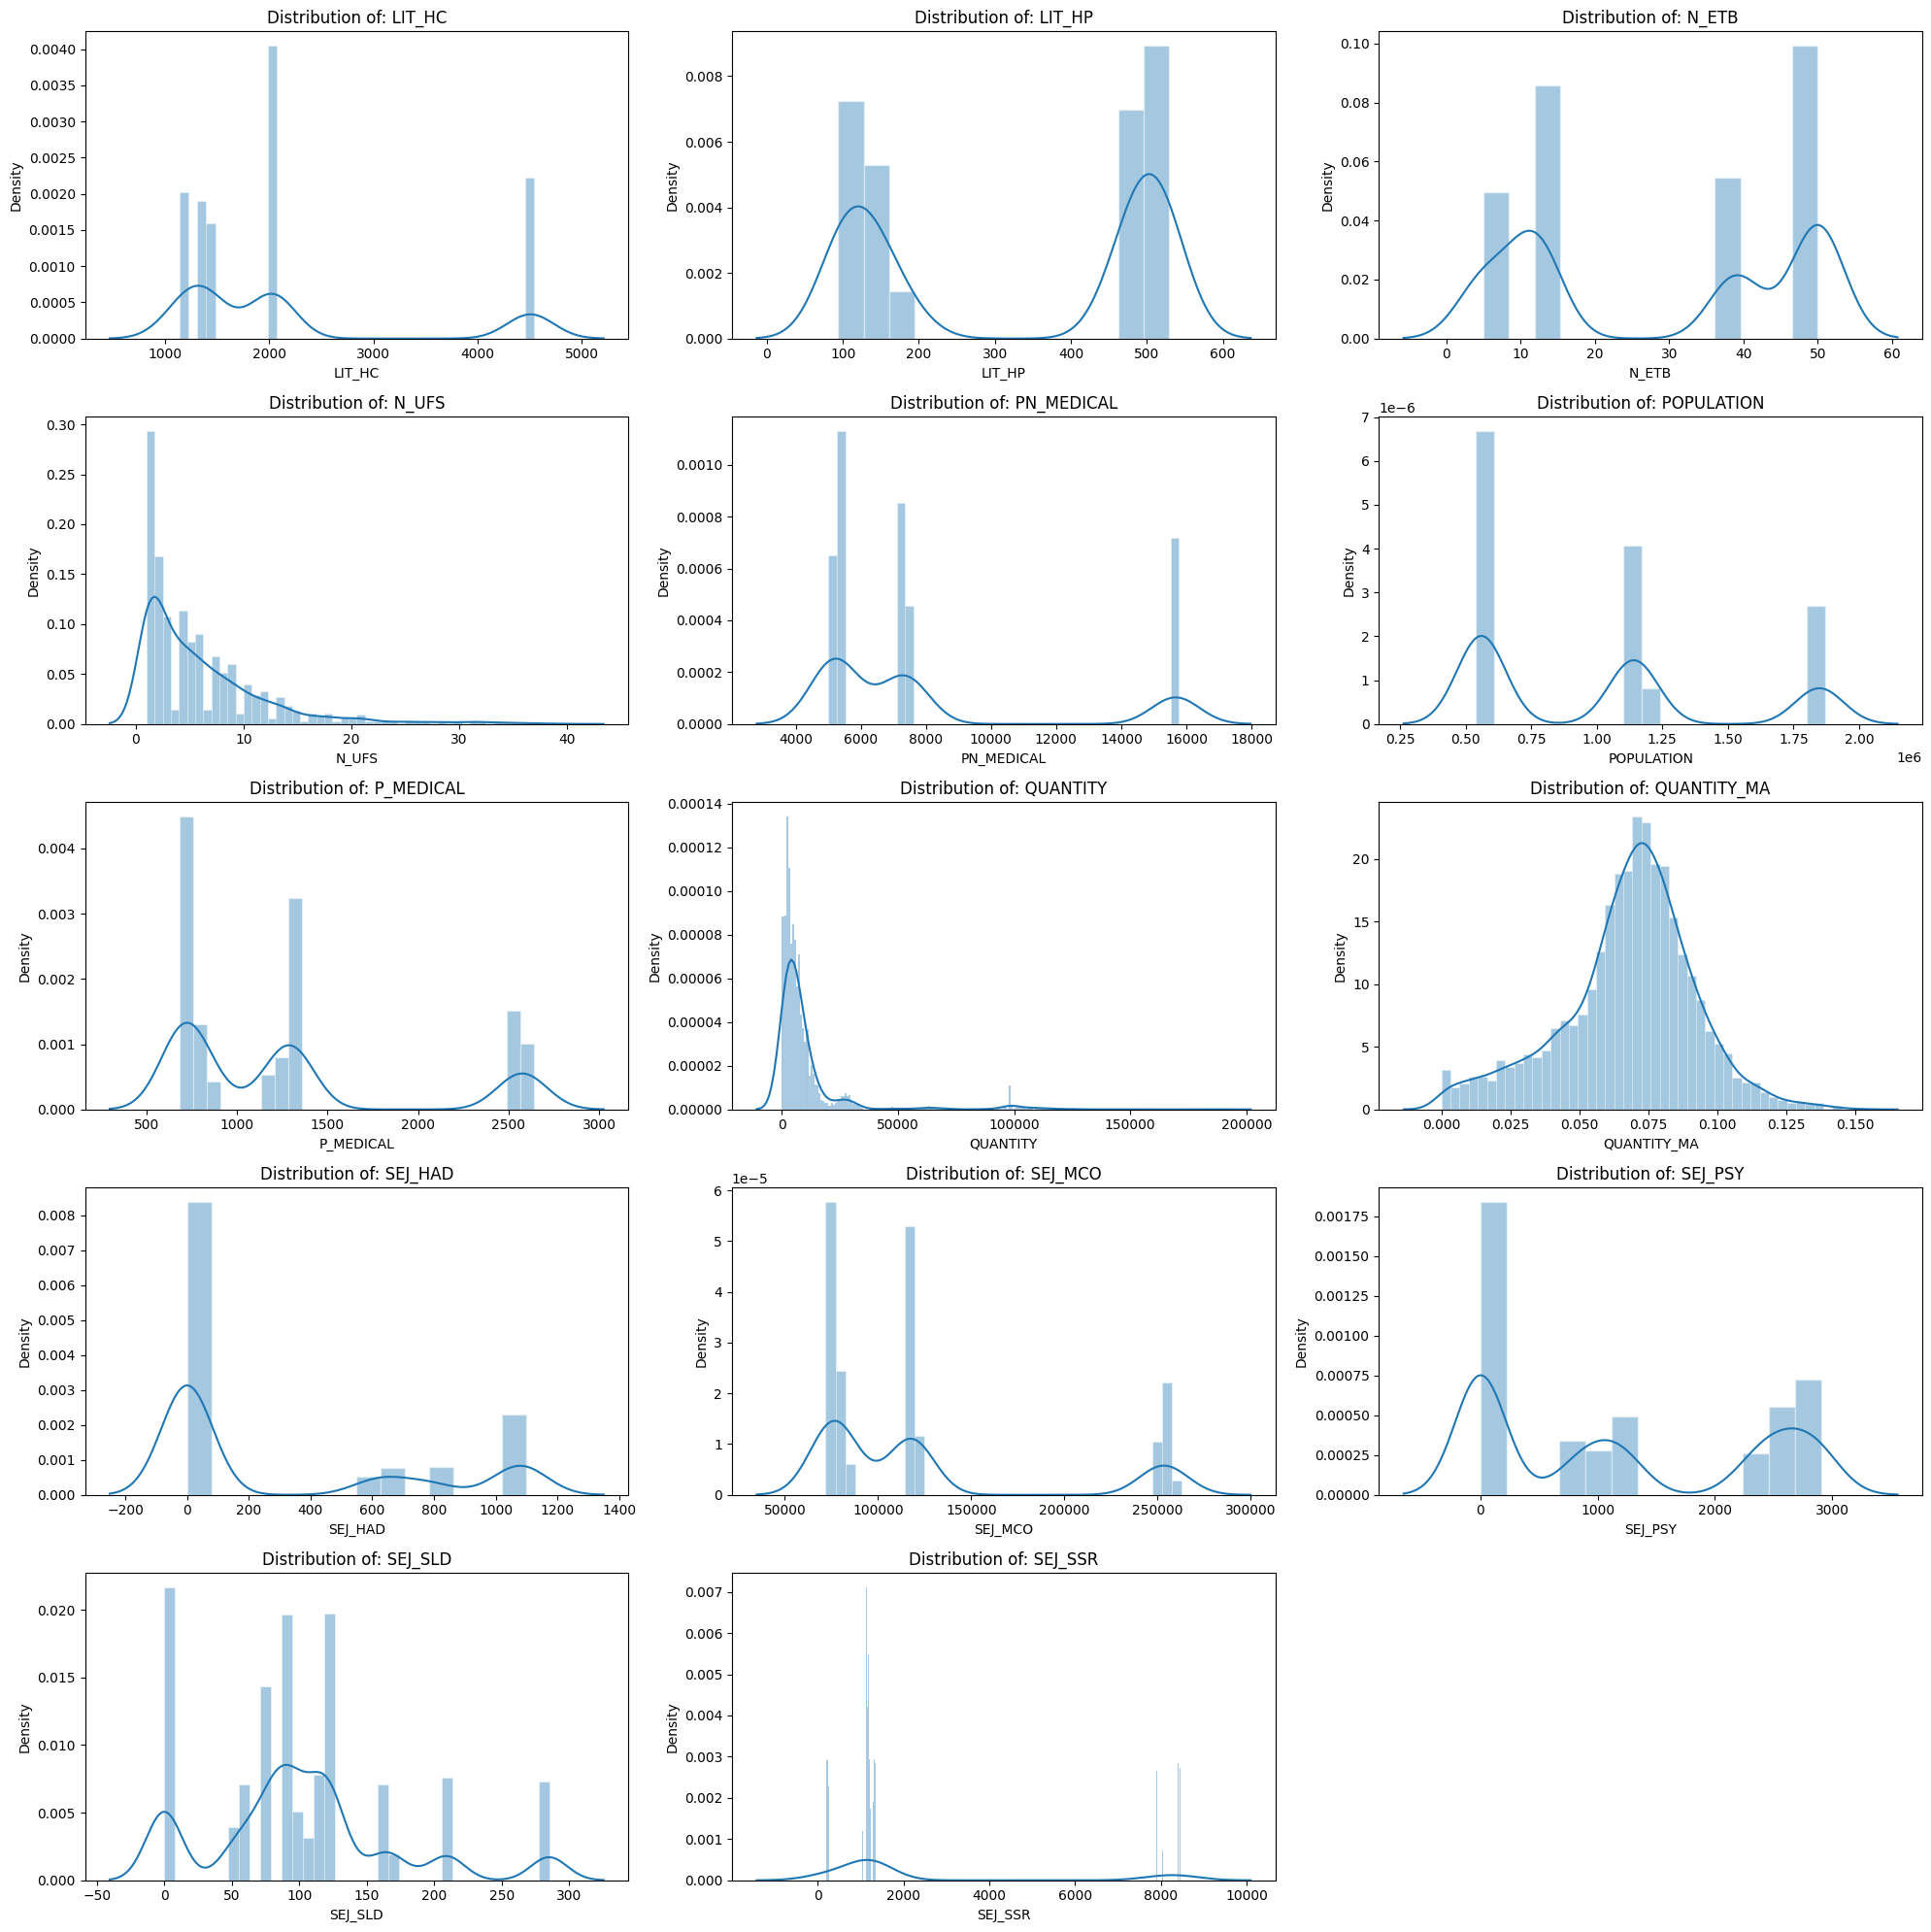

In [ ]:
visualize_distribution(df[numerical_features], data_type='numerical', n_cols=3)

## 4.1 - Train, Test split

In [8]:
X = df.copy().drop(["HOSPI_CODE_UCD"],axis=1).values
X_train, X_test = train_test_split(X, test_size = 0.2, random_state=42, shuffle = True)

## 4.2 - K-means model with different cluster composition
## &
## 4.3 - Model evaluation

In [10]:
def kmeans_clustering(X, n_clusters=2):
    model = KMeans(n_clusters=n_clusters,
                   init = 'k-means++',
                   n_init=1,
                   max_iter=10,
                   random_state=42)
    model.fit(X)
    return model

In [11]:
from sklearn.cluster import MiniBatchKMeans

def minibatch_kmeans_clustering(X, n_clusters=2):
    model = MiniBatchKMeans(n_clusters=n_clusters,
                            init='k-means++',
                            n_init=1,
                            batch_size=10,
                            max_iter=10,
                            random_state=42)
    model.fit(X)
    return model

In [12]:
def evaluate_kmeans_clustering(X_train, X_test, n_clusters=2, metric='euclidean', verbose = False, algorithm = 'k-means'):

    if algorithm == 'k-means':
      model = kmeans_clustering(X_train, n_clusters)

    elif algorithm == 'mini-batch':
      model = minibatch_kmeans_clustering(X_train, n_clusters)

    y_pred = model.predict(X_test)

    silhouette = metrics.silhouette_score(X_test, y_pred, metric=metric)
    davies_bouldin = metrics.davies_bouldin_score(X_test, y_pred)

    if verbose:
      metrics_string = '#'*10+' Metrics for test split - '+f'{n_clusters} clusters '+'#'*10
      print()
      print('#'*len(metrics_string))
      print(metrics_string)
      print()
      print(f'Silhouette Score: {round(silhouette, 2)}')
      print(f'Davies-Bouldin Score: {round(davies_bouldin, 2)}')
      print()
      print('#'*len(metrics_string))
      print('#'*len(metrics_string))
      print()

    return silhouette, davies_bouldin

In [17]:
def visualize_kmeans_clustering_metrics(min_clusters, max_clusters, s_scores, dbs_scores):

  # Find optimal cluster numbers based on the scores
  s_max = np.argmax(s_scores)+2
  dbs_min = np.argmin(dbs_scores)+2

  # Print the best scores and cluster numbers
  string_array = '#'*10 + ' Metrics best performance for different clusters ' + '#'*10
  len_string_array = len(string_array)
  print('-' * len_string_array)
  print('-' * len_string_array)
  print()
  print(string_array)
  print(f'Best score for Silhouette metric: {max(s_scores):.2f} for {s_max} clusters')
  print(f'Best score for Davies Bouldin metric: {min(dbs_scores):.2f} for {dbs_min} clusters')
  print()
  print('-' * len_string_array)
  print('-' * len_string_array)
  print()

  # Plot Silhouette scores
  x = np.arange(min_clusters, max_clusters+1)
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

  # Plot Silhouette scores
  axs[0].stem(x, s_scores, linefmt='C0-', markerfmt='C0o', basefmt=' ')
  axs[0].set_xlabel('Number of Clusters')
  axs[0].set_ylabel('Silhouette Score')
  axs[0].set_title('Silhouette Scores for Different Cluster Numbers')
  axs[0].set_xticks(np.arange(2, max_clusters+1, 1))
  axs[0].set_ylim([0, 1])
  axs[0].grid(True)

  # Plot Davies Bouldin Scores
  axs[1].stem(x, dbs_scores, linefmt='C1-', markerfmt='C1o', basefmt=' ')
  axs[1].set_xlabel('Number of Clusters')
  axs[1].set_ylabel('Davies Bouldin Score')
  axs[1].set_title('Davies Bouldin Scores for Different Cluster Numbers')
  axs[1].set_xticks(np.arange(2, max_clusters+1, 1))
  axs[1].set_ylim([0, 1])
  axs[1].grid(True)

  plt.show()

In [7]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.pyplot as plt
import time

def create_elbow_plot(X, max_clusters=10, sample_fraction=0.1):
    # Sample a subset of the data for faster processing (optional)
    n_samples = int(sample_fraction * len(X))
    X_sample = X[:n_samples]

    # Initialize lists to store inertia and training times
    kmeans_inertia = []
    kmeans_train_time = []
    minibatch_inertia = []
    minibatch_train_time = []

    # Perform K-means clustering for different numbers of clusters
    for n_clusters in range(1, max_clusters + 1):
        # Perform K-means clustering
        start_time = time.time()
        kmeans = KMeans(n_clusters=n_clusters,
                        init = 'k-means++',
                        n_init=1,
                        max_iter=10,
                        random_state=42)

        kmeans.fit(X_sample)
        train_time = time.time() - start_time

        # Calculate inertia (within-cluster sum of squares)
        inertia = kmeans.inertia_

        # Append inertia and training time to the respective lists
        kmeans_inertia.append(inertia)
        kmeans_train_time.append(train_time)

    # Perform Mini-Batch K-means clustering for different numbers of clusters
    for n_clusters in range(1, max_clusters + 1):
        # Perform Mini-Batch K-means clustering
        start_time = time.time()
        minibatch_kmeans = MiniBatchKMeans(n_clusters=n_clusters,
                                           init = 'k-means++',
                                           n_init=1,
                                           max_iter=10,
                                           batch_size=10,
                                           random_state=42)
        minibatch_kmeans.fit(X_sample)
        train_time = time.time() - start_time

        # Calculate inertia (within-cluster sum of squares)
        distances = pairwise_distances_argmin_min(X_sample, minibatch_kmeans.cluster_centers_)
        minibatch_inertia.append(sum(distances[1]))

        # Append inertia and training time to the respective lists
        minibatch_train_time.append(train_time)

    # Create the plots
    plt.figure(figsize=(12, 5))

    # Elbow plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, max_clusters + 1), kmeans_inertia, marker='o', label='K-means')
    plt.plot(range(1, max_clusters + 1), minibatch_inertia, marker='o', label='Mini-Batch K-means')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Plot for K-means and Mini-Batch K-means')
    plt.grid(True)
    plt.legend()

    # Training time plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, max_clusters + 1), kmeans_train_time, marker='o', label='K-means')
    plt.plot(range(1, max_clusters + 1), minibatch_train_time, marker='o', label='Mini-Batch K-means')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Training Time (seconds)')
    plt.title('Training Time for K-means and Mini-Batch K-means')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


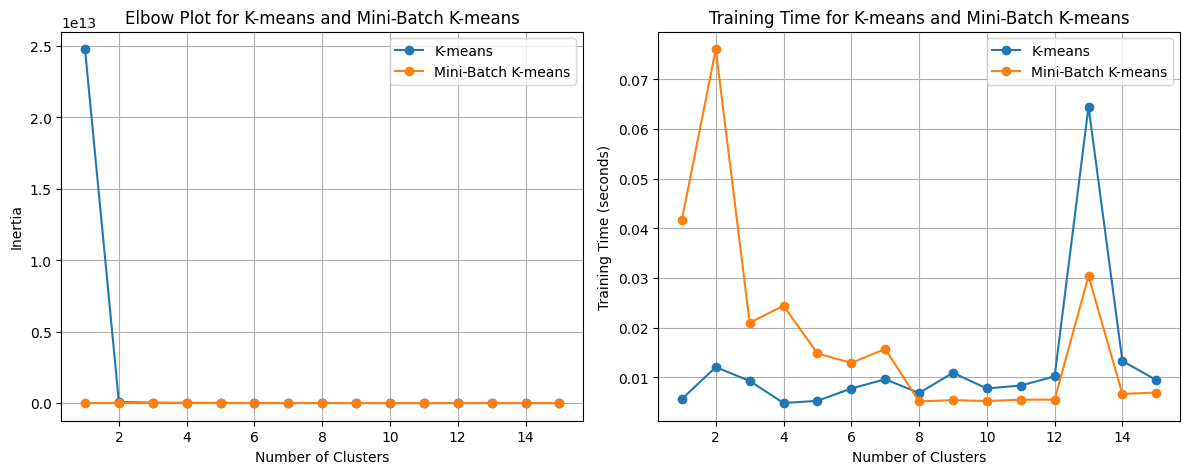

In [9]:
create_elbow_plot(X, max_clusters=15, sample_fraction=0.1)

---------------------------------------------------------------------
---------------------------------------------------------------------

########## Metrics best performance for different clusters ##########
Best score for Silhouette metric: 0.96 for 3 clusters
Best score for Davies Bouldin metric: 0.07 for 3 clusters

---------------------------------------------------------------------
---------------------------------------------------------------------



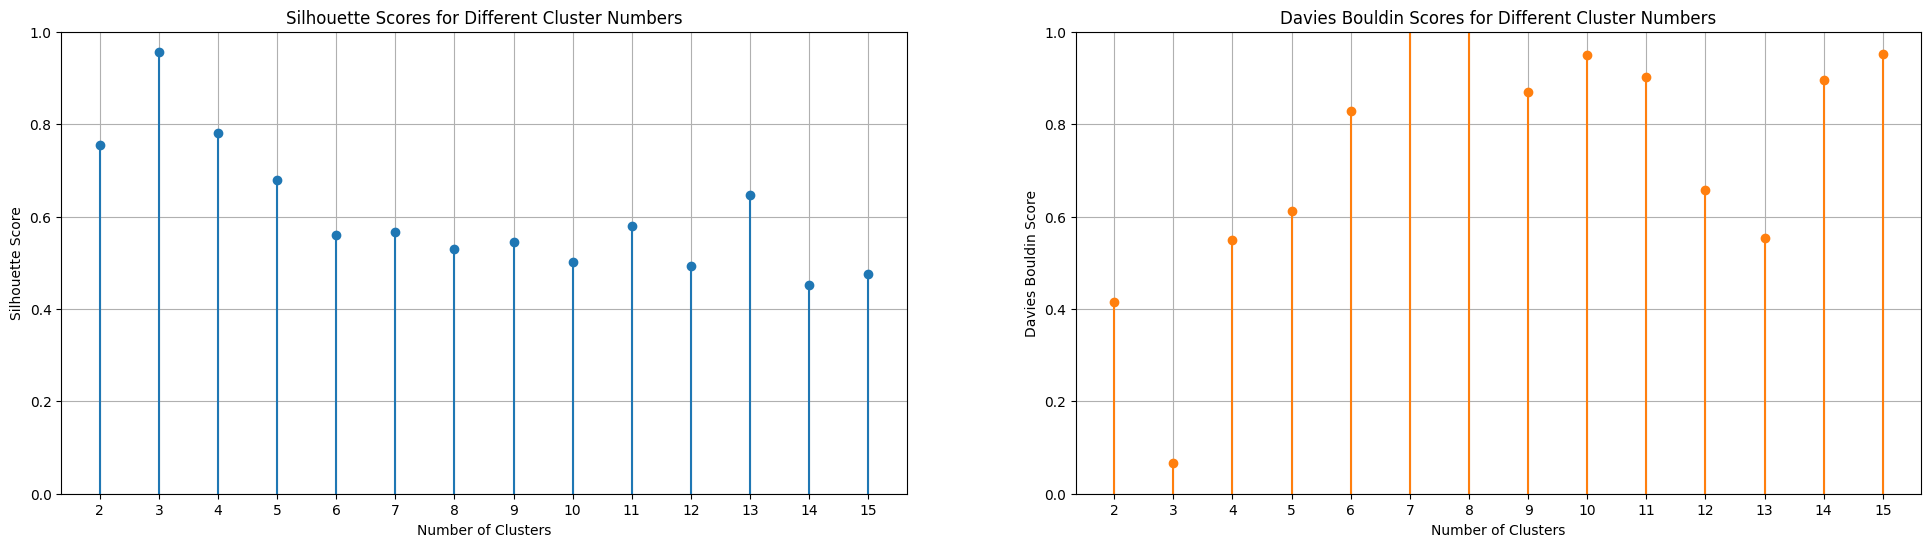

In [18]:
min_clusters = 2
max_clusters = 15

s_scores = np.zeros(max_clusters-1)
dbs_scores = np.zeros(max_clusters-1)

clusters = range(2, max_clusters + 1)

for n_clusters in clusters:

  s_scores[n_clusters-2], dbs_scores[n_clusters-2] =  evaluate_kmeans_clustering(X_train, X_test, n_clusters, algorithm = 'mini-batch')

visualize_kmeans_clustering_metrics(min_clusters, max_clusters, s_scores, dbs_scores)

## 4.4 - Fit test

In [19]:
from IPython.display import display

def model_validation(df, X, n_clusters = 2):

  model = MiniBatchKMeans(n_clusters=n_clusters,
                          init='k-means++',
                          n_init=1,
                          batch_size=10,
                          max_iter=10,
                          random_state=42)

  labels  = model.fit_predict(X)

  df['cluster'] = labels

  return labels

In [20]:
import plotly.express as px

def visu_clusters(df, x1, x2, labels):
    fig = px.scatter(df, x=df[x1].astype('string'), y=df[x2], color=labels)
    fig.update_traces(marker=dict(size=5))
    fig.update_layout(
        title=f'Scatter plot of {x1} over {x2}',
        xaxis_title=x1,
        yaxis_title=x2,
        legend_title="Categories",
        xaxis_tickangle=90,
        showlegend=True
    )
    fig.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def visu_clusters_3d(df1, df2, df3, df4, x1, x2, labels1, labels2, labels3, labels4):
    fig = plt.figure(figsize=(24, 18))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot for Hospital 1
    ax.scatter(df1[x1].astype('string'), np.ones(len(df1)), df1[x2], c=labels1, s=5, cmap='rainbow')

    # Scatter plot for Hospital 2
    ax.scatter(df2[x1].astype('string'), 2 * np.ones(len(df2)), df2[x2], c=labels2, s=5, cmap='rainbow')

    # Scatter plot for Hospital 3
    ax.scatter(df3[x1].astype('string'), 3 * np.ones(len(df3)), df3[x2], c=labels3, s=5, cmap='rainbow')

    # Scatter plot for Hospital 4
    ax.scatter(df4[x1].astype('string'), 4 * np.ones(len(df4)), df4[x2], c=labels4, s=5, cmap='rainbow')

    # Set labels and title
    ax.set_xlabel(x1)
    ax.set_ylabel('Hospital')
    ax.set_zlabel(x2)
    ax.set_title('3D Scatter Plot')

    # Set y-ticks and labels for hospitals
    ax.set_yticks([1, 2, 3, 4])
    ax.set_yticklabels(['Hospital 1', 'Hospital 2', 'Hospital 3', 'Hospital 4'])

    # Increase space between ticks and axis label
    ax.tick_params(axis='x', rotation=90, pad=10)
    ax.tick_params(axis='y', pad=10)

    # Show the plot
    plt.show()


In [25]:
labels = model_validation(df.copy(),
                             X,
                             n_clusters = 5)

visu_clusters(df.copy(),
              'HOSPI_CODE_UCD', 'QUANTITY',
              ['cat_' + str(s) for s in labels])

### Saving the datasets with clusters

In [26]:
df['CLUSTER'] = labels

df.to_csv('df_clustered_5.csv', index=False)